# Iberdrola Project - Phase 2 [Occupancy Detection]

# Test GPU (Optional)
Before Starting, kindly check the available GPU from the Google Server, GPU model and other related information. It might help!

In [1]:
import torch
print("Is CUDA enabled GPU Available?", torch.cuda.is_available())
print("GPU Number:", torch.cuda.device_count())
print("Current GPU Index:", torch.cuda.current_device())
print("GPU Type:", torch.cuda.get_device_name(device=None))
print("GPU Capability:", torch.cuda.get_device_capability(device=None))
print("Is GPU Initialized yet?", torch.cuda.is_initialized())
print(torch.__version__)

Is CUDA enabled GPU Available? True
GPU Number: 1
Current GPU Index: 0
GPU Type: NVIDIA GeForce RTX 3080 Ti Laptop GPU
GPU Capability: (8, 6)
Is GPU Initialized yet? True
2.1.2+cu121


# Import Libraries

In [2]:
import os
import h5py
import scipy
import random
import pickle
import json
import configparser
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.io import loadmat, savemat
from pathlib import Path
from tqdm import tqdm
from scipy import stats
from random import shuffle

2025-03-15 03:25:59.838174: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-15 03:25:59.852346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741998359.871178   96792 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741998359.877496   96792 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-15 03:25:59.897237: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
%matplotlib inline
sns.set_style('white')

# Study Configurations

In [4]:
task_num = 2
fold_num = 5

# Import and Prepare Data

## Import and Concatenate Data

In [ ]:
# Import
fl_Data_H01 = loadmat('Occupancy_Data_Curated_House_01_V2.mat')
X_Data_H01 = fl_Data_H01['X_Data']
Y_Data_H01 = fl_Data_H01['Y_Data']
H01_array = np.ones((X_Data_H01.shape[0],1))*1
print(X_Data_H01.shape)
print(Y_Data_H01.shape)
print(H01_array.shape)
fl_Data_H02 = loadmat('Occupancy_Data_Curated_House_02_V2.mat')
X_Data_H02 = fl_Data_H02['X_Data']
Y_Data_H02 = fl_Data_H02['Y_Data']
H02_array = np.ones((X_Data_H02.shape[0],1))*2
print(X_Data_H02.shape)
print(Y_Data_H02.shape)
print(H02_array.shape)
fl_Data_H03 = loadmat('Occupancy_Data_Curated_House_03.mat')
X_Data_H03 = fl_Data_H03['X_Data']
Y_Data_H03 = fl_Data_H03['Y_Data']
H03_array = np.ones((X_Data_H03.shape[0],1))*3
print(X_Data_H03.shape)
print(Y_Data_H03.shape)
print(H03_array.shape)
fl_Data_H04 = loadmat('Occupancy_Data_Curated_House_04_V2.mat')
X_Data_H04 = fl_Data_H04['X_Data']
Y_Data_H04 = fl_Data_H04['Y_Data']
H04_array = np.ones((X_Data_H04.shape[0],1))*4
print(X_Data_H04.shape)
print(Y_Data_H04.shape)
print(H04_array.shape)
fl_Data_H05 = loadmat('Occupancy_Data_Curated_House_05_V2.mat')
X_Data_H05 = fl_Data_H05['X_Data']
Y_Data_H05 = fl_Data_H05['Y_Data']
H05_array = np.ones((X_Data_H05.shape[0],1))*5
print(X_Data_H05.shape)
print(Y_Data_H05.shape)
print(H05_array.shape)
# X_Data = X_Data_H01
# Y_Data = Y_Data_H01
# House_array = H01_array
# Combine
X_Data = np.concatenate((X_Data_H01,X_Data_H02,X_Data_H04,X_Data_H05), axis=0)
Y_Data = np.concatenate((Y_Data_H01,Y_Data_H02,Y_Data_H04,Y_Data_H05), axis=0)
House_array = np.int_(np.concatenate((H01_array,H02_array,H04_array,H05_array), axis=0))
print(X_Data.shape)
print(Y_Data.shape)
print(House_array.shape)
print(np.int_(np.transpose(House_array)))
sample_num = X_Data.shape[0]
segment_length = X_Data.shape[1]
num_channels = X_Data.shape[2]

Plot Aggregated Ground Truth

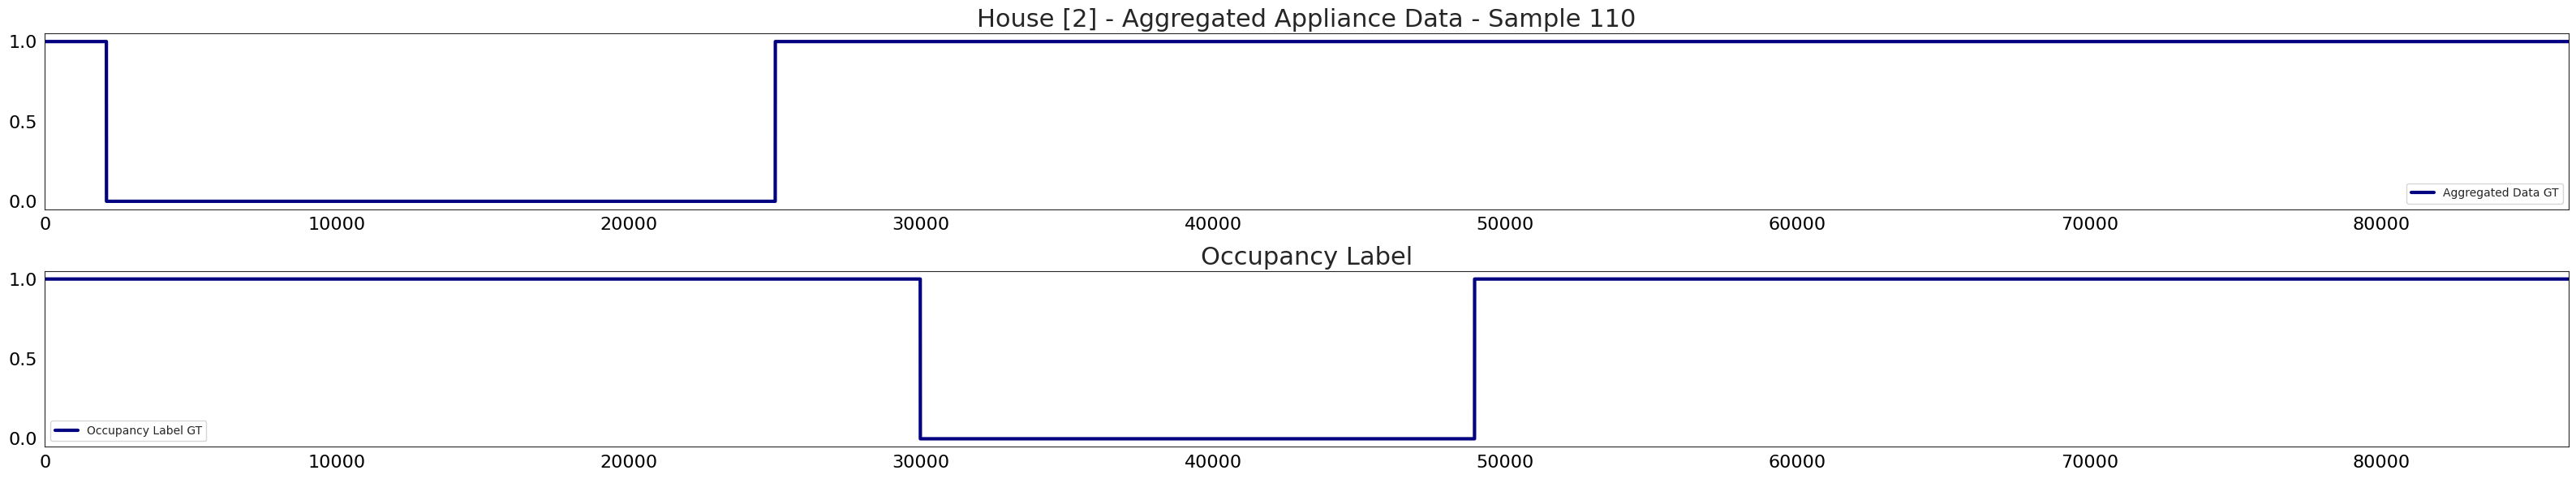

In [6]:
segment_length = 86400
i = random.randint(0, X_Data.shape[0]-1)
'''Dishwasher'''
plt.figure(figsize=(32,6))
plt.subplot(2,1,1)
plt.plot(X_Data[i,:,0], linewidth=3, label='Aggregated Data GT', color='navy')
plt.title(f"House {np.int_(House_array[i])} - Aggregated Appliance Data - Sample {i}", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Occupancy Label'''
plt.subplot(2,1,2)
plt.plot(Y_Data[i,:,0], linewidth=3, label='Occupancy Label GT', color='navy')
plt.title(f"Occupancy Label", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

In [7]:
ind_list = [i for i in range(sample_num)]
shuffle(ind_list)
X_Data  = X_Data[ind_list,:,:]
Y_Data = Y_Data[ind_list,:,:]
House_array  = House_array[ind_list,:]
print(X_Data.shape)
print(Y_Data.shape)
print(House_array.shape)
print(np.int_(np.transpose(House_array)))

(199, 86400, 1)
(199, 86400, 1)
(199, 1)
[[2 4 4 2 2 4 2 5 2 2 2 4 2 4 2 4 2 4 2 1 2 4 5 2 4 2 2 5 2 1 5 4 5 2 4 2
  4 2 2 2 2 2 4 2 2 2 2 4 1 5 2 2 2 2 2 2 1 2 2 1 2 2 5 2 2 5 2 5 2 2 4 2
  4 1 2 4 4 4 2 2 2 4 4 2 2 5 5 1 5 4 2 2 2 1 2 5 4 4 2 4 2 4 2 2 5 4 2 2
  2 1 2 2 5 2 1 1 2 2 5 5 4 2 2 5 4 4 4 2 4 1 2 4 4 2 2 2 1 2 2 2 5 2 2 5
  1 2 2 2 2 4 2 2 2 5 1 2 5 2 2 4 2 2 4 5 4 5 2 2 4 2 2 2 4 2 5 2 2 5 5 5
  4 4 2 2 2 5 2 4 2 2 2 2 5 2 2 2 2 2 5]]


## Create Folds

### Train and Test Sets - Random Split - 20% for Test - 10% for Validation

In [8]:
X_Train, X_Test, Y_Train, Y_Test, HA_Train, HA_Test = train_test_split(X_Data, Y_Data, House_array, test_size=0.2, random_state=0)
X_Val = X_Test
Y_Val = Y_Test
print(X_Train.shape)
print(Y_Train.shape)
print(X_Test.shape)
print(Y_Test.shape)
print(X_Val.shape)
print(Y_Val.shape)

(159, 86400, 1)
(159, 86400, 1)
(40, 86400, 1)
(40, 86400, 1)
(40, 86400, 1)
(40, 86400, 1)


### Or house-independent folds

In [22]:
if fold_num == 1:
    train_house_IDs = [1,2,4]
    test_house_IDs = [5]
elif fold_num == 2:
    train_house_IDs = [1,2,5]
    test_house_IDs = [4]
elif fold_num == 3:
    train_house_IDs = [1,4,5]
    test_house_IDs = [2]
elif fold_num == 4:
    train_house_IDs = [2,4,5]
    test_house_IDs = [1]
train_Indices = np.where(House_array == train_house_IDs)[0]
X_Train = np.take(X_Data, train_Indices, axis=0)
Y_Train = np.take(Y_Data, train_Indices, axis=0)
test_Indices = np.where(House_array == test_house_IDs)[0]
X_Test = np.take(X_Data, test_Indices, axis=0)
Y_Test = np.take(Y_Data, test_Indices, axis=0)
Y_Test_House_Labels = np.take(House_array, test_Indices, axis=0)
X_Val = X_Test
Y_Val = Y_Test
print(X_Train.shape)
print(Y_Train.shape)
print(X_Test.shape)
print(Y_Test.shape)
print(X_Val.shape)
print(Y_Val.shape)
print(Y_Test_House_Labels.shape)

(285, 86400, 1)
(285, 86400, 1)
(74, 86400, 1)
(74, 86400, 1)
(74, 86400, 1)
(74, 86400, 1)
(74, 1)


### Or Manual Split

In [9]:
if fold_num == 1:
    X_Train = X_Data[0:round((sample_num/5)*4),:,:]
    X_Test = X_Data[round((sample_num/5)*4):,:,:]
    Y_Train = Y_Data[0:round((sample_num/5)*4),:,:]
    Y_Test = Y_Data[round((sample_num/5)*4):,:,:]
    HA_Train = House_array[0:round((sample_num/5)*4),:]
    HA_Test = House_array[round((sample_num/5)*4):,:]               
elif fold_num == 2:
    X_Train1 = X_Data[0:round((sample_num/5)*3),:,:]
    X_Train2 = X_Data[round((sample_num/5)*4):,:,:]
    X_Train = np.concatenate((X_Train1,X_Train2), axis=0)
    X_Test = X_Data[round((sample_num/5)*3):round((sample_num/5)*4),:,:]
    Y_Train1 = Y_Data[0:round((sample_num/5)*3),:,:]
    Y_Train2 = Y_Data[round((sample_num/5)*4):,:,:]
    Y_Train = np.concatenate((Y_Train1,Y_Train2), axis=0)
    Y_Test = Y_Data[round((sample_num/5)*3):round((sample_num/5)*4),:,:]
    HA_Train1 = House_array[0:round((sample_num/5)*3),:]
    HA_Train2 = House_array[round((sample_num/5)*4):,:]
    HA_Train = np.concatenate((HA_Train1,HA_Train2), axis=0)
    HA_Test = House_array[round((sample_num/5)*3):round((sample_num/5)*4),:]
elif fold_num == 3:
    X_Train1 = X_Data[0:round((sample_num/5)*2),:,:]
    X_Train2 = X_Data[round((sample_num/5)*3):,:,:]
    X_Train = np.concatenate((X_Train1,X_Train2), axis=0)
    X_Test = X_Data[round((sample_num/5)*2):round((sample_num/5)*3),:,:]
    Y_Train1 = Y_Data[0:round((sample_num/5)*2),:,:]
    Y_Train2 = Y_Data[round((sample_num/5)*3):,:,:]
    Y_Train = np.concatenate((Y_Train1,Y_Train2), axis=0)
    Y_Test = Y_Data[round((sample_num/5)*2):round((sample_num/5)*3),:,:]
    HA_Train1 = House_array[0:round((sample_num/5)*2),:]
    HA_Train2 = House_array[round((sample_num/5)*3):,:]
    HA_Train = np.concatenate((HA_Train1,HA_Train2), axis=0)
    HA_Test = House_array[round((sample_num/5)*2):round((sample_num/5)*3),:]
elif fold_num == 4:
    X_Train1 = X_Data[0:round((sample_num/5)*1),:,:]
    X_Train2 = X_Data[round((sample_num/5)*2):,:,:]
    X_Train = np.concatenate((X_Train1,X_Train2), axis=0)
    X_Test = X_Data[round((sample_num/5)*1):round((sample_num/5)*2),:,:]
    Y_Train1 = Y_Data[0:round((sample_num/5)*1),:,:]
    Y_Train2 = Y_Data[round((sample_num/5)*2):,:,:]
    Y_Train = np.concatenate((Y_Train1,Y_Train2), axis=0)
    Y_Test = Y_Data[round((sample_num/5)*1):round((sample_num/5)*2),:,:]
    HA_Train1 = House_array[0:round((sample_num/5)*1),:]
    HA_Train2 = House_array[round((sample_num/5)*2):,:]
    HA_Train = np.concatenate((HA_Train1,HA_Train2), axis=0)
    HA_Test = House_array[round((sample_num/5)*1):round((sample_num/5)*2),:]
elif fold_num == 5:
    X_Train = X_Data[round((sample_num/5)*1):,:,:]
    X_Test = X_Data[0:round((sample_num/5)*1),:,:]
    Y_Train = Y_Data[round((sample_num/5)*1):,:,:]
    Y_Test = Y_Data[0:round((sample_num/5)*1),:,:]
    HA_Train = House_array[round((sample_num/5)*1):,:]
    HA_Test = House_array[0:round((sample_num/5)*1),:] 
X_Val = X_Test
Y_Val = Y_Test
print(X_Train.shape)
print(Y_Train.shape)
print(X_Test.shape)
print(Y_Test.shape)
print(X_Val.shape)
print(Y_Val.shape)
print(HA_Train.shape)
print(HA_Test.shape)

(159, 86400, 1)
(159, 86400, 1)
(40, 86400, 1)
(40, 86400, 1)
(40, 86400, 1)
(40, 86400, 1)
(159, 1)
(40, 1)


## Prepare data for classification (Method 1)

### Augment Train Set through overlapping

In [10]:
def overlap_data(X_Data, Y_Data, overlap_ratio, target_segment_length):
    # Input Array Shape
    X_Data_Shape = X_Data.shape
    Y_Data_Shape = Y_Data.shape
    original_segment_length = X_Data_Shape[1]
    # Reshape Array
    X_Data_Reshaped = np.reshape(X_Data, (X_Data_Shape[0]*X_Data_Shape[1], X_Data_Shape[2]))
    Y_Data_Reshaped = np.reshape(Y_Data, (X_Data_Shape[0]*X_Data_Shape[1], Y_Data_Shape[2]))
    X_Data_Reshaped_Shape = X_Data_Reshaped.shape
    Y_Data_Reshaped_Shape = Y_Data_Reshaped.shape
    # Overlap
    offset_amount = np.int_(original_segment_length*(1 - overlap_ratio))
    X_Data_New = np.zeros((10000,target_segment_length,X_Data_Reshaped_Shape[1]))
    Y_Data_New = np.zeros((10000,target_segment_length,Y_Data_Reshaped_Shape[1]))
    num_segments_approx = np.int_(np.ceil(X_Data_Reshaped_Shape[0]/offset_amount))
    counter = 0
    for i in range(0,num_segments_approx):
        if (i*offset_amount+target_segment_length) > X_Data_Reshaped_Shape[0]:
            continue
        X_Data_Temp = X_Data_Reshaped[i*offset_amount:i*offset_amount+target_segment_length,:]
        # X_Data_Temp = (X_Data_Temp - np.min(X_Data_Temp))/(np.max(X_Data_Temp)-np.min(X_Data_Temp))  # Range Normalization [0 1]
        X_Data_New[counter,:,:] = X_Data_Temp
        Y_Data_Temp = Y_Data_Reshaped[i*offset_amount:i*offset_amount+target_segment_length,:]
        # Y_Data_Temp = (Y_Data_Temp - np.min(Y_Data_Temp))/(np.max(Y_Data_Temp)-np.min(Y_Data_Temp))
        Y_Data_New[counter,:,:] = Y_Data_Temp
        counter = counter + 1
    X_Data_OVRL = X_Data_New[0:counter,:,:]
    Y_Data_OVRL = Y_Data_New[0:counter,:,:]
    
    return X_Data_OVRL, Y_Data_OVRL

In [ ]:
def overlap_data(X_Data, Y_Data, overlap_ratio, target_segment_length):
    # Input Array Shape
    X_Data_Shape = X_Data.shape
    Y_Data_Shape = Y_Data.shape
    original_segment_length = X_Data_Shape[1]
    # Reshape Array
    X_Data_Reshaped = np.reshape(X_Data, (X_Data_Shape[0]*X_Data_Shape[1], X_Data_Shape[2]))
    Y_Data_Reshaped = np.reshape(Y_Data, (X_Data_Shape[0]*X_Data_Shape[1], Y_Data_Shape[2]))
    X_Data_Reshaped_Shape = X_Data_Reshaped.shape
    Y_Data_Reshaped_Shape = Y_Data_Reshaped.shape
    # Overlap
    offset_amount = np.int_(original_segment_length*(1 - overlap_ratio))
    X_Data_New = np.zeros((10000,target_segment_length,X_Data_Reshaped_Shape[1]))
    Y_Data_New = np.zeros((10000,target_segment_length,Y_Data_Reshaped_Shape[1]))
    num_segments_approx = np.int_(np.ceil(X_Data_Reshaped_Shape[0]/offset_amount))
    counter = 0
    for i in range(0,num_segments_approx):
        if (i*offset_amount+target_segment_length) > X_Data_Reshaped_Shape[0]:
            continue
        X_Data_Temp = X_Data_Reshaped[i*offset_amount:i*offset_amount+target_segment_length,:]
        # X_Data_Temp = (X_Data_Temp - np.min(X_Data_Temp))/(np.max(X_Data_Temp)-np.min(X_Data_Temp))  # Range Normalization [0 1]
        X_Data_New[counter,:,:] = X_Data_Temp
        Y_Data_Temp = Y_Data_Reshaped[i*offset_amount:i*offset_amount+target_segment_length,:]
        # Y_Data_Temp = (Y_Data_Temp - np.min(Y_Data_Temp))/(np.max(Y_Data_Temp)-np.min(Y_Data_Temp))
        Y_Data_New[counter,:,:] = Y_Data_Temp
        counter = counter + 1
    X_Data_OVRL = X_Data_New[0:counter,:,:]
    Y_Data_OVRL = Y_Data_New[0:counter,:,:]
    
    return X_Data_OVRL, Y_Data_OVRL

In [11]:
X_Train_OVRL, Y_Train_OVRL = overlap_data(X_Train, Y_Train, 0.9, 86400)
X_Test_OVRL, Y_Test_OVRL = overlap_data(X_Test, Y_Test, 0.9, 86400)
X_Val_OVRL, Y_Val_OVRL = overlap_data(X_Val, Y_Val, 0.9, 86400)
print(X_Train_OVRL.shape)
print(Y_Train_OVRL.shape)
print(X_Test_OVRL.shape)
print(Y_Test_OVRL.shape)

(1581, 86400, 1)
(1581, 86400, 1)
(391, 86400, 1)
(391, 86400, 1)


### Transform Labels for Classification

In [12]:
def transform_labels(X_Data_OVRL, Y_Data_OVRL, segment_length, num_channels):
    X_Data_New = np.zeros((200000,num_channels,segment_length))
    Y_Data_New = np.zeros((200000,1), dtype=int)
    ## Raw Dataset
    X_Data_Shape = X_Data_OVRL.shape
    Y_Data_Shape = Y_Data_OVRL.shape
    # Reshape Array
    X_Data_Reshaped = np.reshape(X_Data_OVRL, (X_Data_Shape[0]*X_Data_Shape[1], num_channels))
    Y_Data_Reshaped = np.reshape(Y_Data_OVRL, (Y_Data_Shape[0]*Y_Data_Shape[1], 1))
    X_Data_Reshaped_Shape = X_Data_Reshaped.shape
    Y_Data_Reshaped_Shape = Y_Data_Reshaped.shape
    num_segments_approx = np.int_(np.ceil(X_Data_Reshaped_Shape[0]/segment_length))
    counter = 0
    for i in range(0,num_segments_approx):
        if ((i+1)*segment_length) > X_Data_Reshaped_Shape[0]:
            continue
        X_Data_Temp = np.transpose(X_Data_Reshaped[i*segment_length:(i+1)*segment_length,:])
        X_Data_Temp_Mean = np.mean(X_Data_Temp)
        X_Data_Temp_VAR = np.var(X_Data_Temp)
        X_Data_New[counter,:,:] = X_Data_Temp
        Y_Data_Temp = Y_Data_Reshaped[i*segment_length:(i+1)*segment_length,:]
        Y_Data_Temp_Mean = np.mean(Y_Data_Temp)
        Y_Data_Temp_VAR = np.var(Y_Data_Temp)
        Y_Data_Temp_SUM = np.sum(Y_Data_Temp)
        if X_Data_Temp_VAR <= 0.001:
            continue
        # if Y_Data_Temp_VAR <= 0.001:
            # continue
        if (Y_Data_Temp_SUM < np.round(0.1*segment_length)) or (Y_Data_Temp_SUM > np.round(0.90*segment_length)):
            continue
        # if Y_Data_Temp_SUM == segment_length:
            # continue
        if Y_Data_Temp_Mean > 0.5:
            Y_Label = 1
        else:
            Y_Label = 0
        Y_Data_New[counter,:] = Y_Label
        counter = counter + 1
    X_Data_New = X_Data_New[0:counter,:,:]
    Y_Data_New = Y_Data_New[0:counter,:]
    return X_Data_New, Y_Data_New

In [13]:
segment_length = 7200  # 20 Minutes = 1200 Data Points (1 Hz sampling rate)
X_Train_C, Y_Train_C = transform_labels(X_Train_OVRL, Y_Train_OVRL, segment_length, num_channels)
X_Test_C, Y_Test_C = transform_labels(X_Test_OVRL, Y_Test_OVRL, segment_length, num_channels)
X_Val_C, Y_Val_C = transform_labels(X_Test_OVRL, Y_Test_OVRL, segment_length, num_channels)
print(X_Train_C.shape)
print(Y_Train_C.shape)
print(X_Test_C.shape)
print(Y_Test_C.shape)
print(X_Val_C.shape)
print(Y_Val_C.shape)
labels, counts = np.unique(Y_Train_C, return_counts=True)
print(labels, counts)
labels, counts = np.unique(Y_Test_C, return_counts=True)
print(labels, counts)
labels, counts = np.unique(Y_Val_C, return_counts=True)
print(labels, counts)


(1489, 1, 7200)
(1489, 1)
(409, 1, 7200)
(409, 1)
(409, 1, 7200)
(409, 1)
[0 1] [636 853]
[0 1] [164 245]
[0 1] [164 245]


## Prepare data for classification (Method 2)

Transform data for classification (S2P learning)

In [14]:
def transform_labels(X_Data, Y_Data, segment_length, num_channels, offset_amount, C1=True, C2=True):
    X_Data_New = np.zeros((40000,num_channels,segment_length))
    Y_Data_New = np.zeros((40000,1), dtype=int)
    ## Shape of Raw Dataset
    X_Data_Shape = X_Data.shape
    Y_Data_Shape = Y_Data.shape
    # Reshape Array
    X_Data_Reshaped = np.reshape(X_Data, (X_Data_Shape[0]*X_Data_Shape[1], num_channels))
    Y_Data_Reshaped = np.reshape(Y_Data, (Y_Data_Shape[0]*Y_Data_Shape[1], 1))
    X_Data_Reshaped_Shape = X_Data_Reshaped.shape
    Y_Data_Reshaped_Shape = Y_Data_Reshaped.shape
    ## Slide through and generate labels
    counter = 0
    for i in range(0,Y_Data_Reshaped_Shape[0]):
        if (i*offset_amount+segment_length) >= X_Data_Reshaped_Shape[0]:
            continue
        X_Data_Temp = np.transpose(X_Data_Reshaped[i*offset_amount:i*offset_amount+segment_length,:])
        X_Data_Temp_Mean = np.mean(X_Data_Temp)
        X_Data_Temp_VAR = np.var(X_Data_Temp)
        X_Data_New[counter,:,:] = X_Data_Temp
        Y_Data_Temp = Y_Data_Reshaped[i*offset_amount:i*offset_amount+segment_length,:]
        Y_Data_Temp_Mean = np.mean(Y_Data_Temp)
        Y_Data_Temp_VAR = np.var(Y_Data_Temp)
        Y_Data_Temp_SUM = np.sum(Y_Data_Temp)
        if C1 == True:
            if X_Data_Temp_VAR <= 0:
                continue
        if C2 == True:
            if (Y_Data_Temp_SUM < np.round(0.01*segment_length)) or (Y_Data_Temp_SUM > np.round(0.99*segment_length)):
                continue
        if Y_Data_Temp_Mean > 0.5:
            Y_Label = 1
        else:
            Y_Label = 0
        Y_Data_New[counter,:] = Y_Label
        counter = counter + 1
    X_Data_New = X_Data_New[0:counter,:,:]
    Y_Data_New = Y_Data_New[0:counter,:]
    return X_Data_New, Y_Data_New

In [15]:
segment_length = 3600  # 20 Minutes = 1200 Data Points (1 Hz sampling rate)
X_Train_C, Y_Train_C = transform_labels(X_Train, Y_Train, segment_length, num_channels, 60, True, True)
X_Test_C, Y_Test_C = transform_labels(X_Test, Y_Test, segment_length, num_channels, 60, True, True)
X_Val_C, Y_Val_C = transform_labels(X_Test, Y_Test, segment_length, num_channels, 60, True, True)
print(X_Train_C.shape)
print(Y_Train_C.shape)
print(X_Test_C.shape)
print(Y_Test_C.shape)
print(X_Val_C.shape)
print(Y_Val_C.shape)
labels, counts = np.unique(Y_Train_C, return_counts=True)
print(labels, counts)
labels, counts = np.unique(Y_Test_C, return_counts=True)
print(labels, counts)
labels, counts = np.unique(Y_Val_C, return_counts=True)
print(labels, counts)

(9506, 1, 3600)
(9506, 1)
(2655, 1, 3600)
(2655, 1)
(2655, 1, 3600)
(2655, 1)
[0 1] [4278 5228]
[0 1] [1219 1436]
[0 1] [1219 1436]


## Balance train set (if required)

In [37]:
Y_Train_0_indices = np.where(Y_Train_C == 0)[0]
X_Train_C_0 = np.take(X_Train_C, Y_Train_0_indices, axis=0)
Y_Train_C_0 = np.take(Y_Train_C, Y_Train_0_indices, axis=0)
Y_Train_1_indices = np.where(Y_Train_C == 1)[0]
X_Train_C_1 = np.take(X_Train_C, Y_Train_1_indices, axis=0)
Y_Train_C_1 = np.take(Y_Train_C, Y_Train_1_indices, axis=0)
#
Y_Train_C_0_shape = Y_Train_C_0.shape
Y_Train_C_1_shape = Y_Train_C_1.shape
Y_Train_C_shape = Y_Train_C.shape
if Y_Train_C_1_shape[0] > Y_Train_C_0_shape[0]:
    index = np.random.choice(Y_Train_C_1_shape[0], Y_Train_C_0_shape[0], replace=False)
    X_Train_1 = X_Train_C_1[index]
    Y_Train_1 = Y_Train_C_1[index]
    X_Train = np.concatenate([X_Train_C_0, X_Train_1], axis=0)
    Y_Train = np.concatenate([Y_Train_C_0, Y_Train_1], axis=0)
elif Y_Train_C_0_shape[0] > Y_Train_C_1_shape[0]:
    index = np.random.choice(Y_Train_C_0_shape[0], Y_Train_C_1_shape[0], replace=False)
    X_Train_0 = X_Train_C_0[index]
    Y_Train_0 = Y_Train_C_0[index]
    X_Train = np.concatenate([X_Train_C_1, X_Train_0], axis=0)
    Y_Train = np.concatenate([Y_Train_C_1, Y_Train_0], axis=0)
#
X_Train_C = X_Train
Y_Train_C = Y_Train
print(X_Train_C.shape)
print(Y_Train_C.shape)

(2812, 1, 1800)
(2812, 1)


## Save preprocessed data

In [16]:
train_data_dic = {"X_Train": X_Train_C,
                  "Y_Train": Y_Train_C,
                  "X_Test": X_Test_C,
                  "Y_Test": Y_Test_C,
                  "X_Val": X_Test_C,
                  "Y_Val": Y_Test_C,
                  }
savemat(f"Data/Data_Fold_{fold_num}.mat", train_data_dic, format='5')

## Garbage Collector

In [ ]:
import gc #Garbage Collector
fl_Data = None
X_Test = None
X_Train = None
X_Val = None
Y_Test = None
Y_Train = None
Y_Val = None
gc.collect()

0

# MAIN

## Configurations

In [5]:
# CREATE OBJECT
config_file = configparser.ConfigParser()
# ADD NEW SECTION AND SETTINGS
config_file["TRAIN"] = {
    'parentdir': '',  # Root or Parent Directory
    'datafile': 'Data',  # Folder containing the dataset
    'val_size': 0.0,  # Validation percentage for splitting
    'q_order': 3,  # q-order for the Self-ONN or Super-ONN Models
    'batch_size': 16,  # Batch Size, Change to fit hardware
    'lossType': 'MSE',  # loss function: 'SoftM_CELoss' or 'SoftM_MSE' or 'MSE'
    'optim_fc': 'SGD',  # 'Adam' or 'SGD'
    'lr': 0.0001,  # learning rate
    'stop_criteria': 'accuracy',  # Stopping criteria: 'loss' or 'accuracy'
    'n_epochs': 500,  # number of training epochs
    'epochs_patience': 6,
    'lr_factor': 0.1,  # lr_factor, if val loss did not decrease for a number of epochs (epochs_patience) then decrease learning rate by a factor of lr_factor
    'max_epochs_stop': 30,  # maximum number of epochs with no improvement in validation loss for early stopping
    'num_folds': 1,  # number of cross validation folds
    'load_model': False,  # load model: True or False
    'load_model_path': f'Results_Classification\ODNet_Occp_Classification\Fold_{fold_num}\ODNet_Occp_Classification_fold_{fold_num}.pt',  # specify path of pretrained model wieghts or set to False to train from scratch
    'model_to_load': 'ODNet',  # choose one of the following models: 'CNN_1' 'CNN_2' 'CNN_2' 'CNN_3' 'SelfResNet18' 'ResNet'
    'model_name': 'ODNet_Occp_Classification',  # choose a unique name for result folder
    'aux_logits': False,  # Required for models with auxilliary outputs (e.g., InceptionV3)  
    'fold_start': fold_num,  # The starting fold for training
    'fold_last': fold_num,  # The last fold for training
    'results_path': 'Results_Classification',  # main results folder
}

# SAVE CONFIG FILE
with open(r"Config_Train.ini", 'w') as configfileObj:
    config_file.write(configfileObj)
    configfileObj.flush()
    configfileObj.close()

print("Config file 'Config_Train.ini' created")

Config file 'Config_Train.ini' created


## Train

In [ ]:
%run -i Train.py

## Test

In [5]:
# CREATE OBJECT
config_file = configparser.ConfigParser()
# ADD NEW SECTION AND SETTINGS
config_file["TEST"] = {
    'parentdir': '',  # Root or Parent Directory
    'datafile': 'Data',  # Folder containing the dataset
    'batch_size': 8,  # Batch Size, Change to fit hardware
    'lossType': 'MSE',  # loss function: 'SoftM_CELoss' or 'SoftM_MSE' or 'MSE'
    'num_folds': 1,  # number of cross validation folds
    'CI': 0.9,  # Confidence interval (missied cases with probability>=CI will be reported in excel file)
    'load_model': False,  # specify path of pretrained model wieghts or set to False to train from scratch
    'load_model_path': f'Results_Classification\ODNet_Occp_Classification\Fold_{fold_num}\ODNet_Occp_Classification_fold_{fold_num}.pt',  # specify path of pretrained model wieghts or set to False to train from scratch
    'labeled_data': True,  # set to true if you have the labeled test set
    'model_name': 'ODNet_Occp_Classification',  # name of the saved model
    'aux_logits': False,  # Required for models with auxilliary outputs (e.g., InceptionV3)  
    'fold_start': fold_num,  # The starting fold for training
    'fold_last': fold_num,  # The last fold for training
    'N_steps': 1000,  # The last fold for training
    'results_path': 'Results_Classification',  # main results folder
}
# SAVE CONFIG FILE
with open(r"Config_Test.ini", 'w') as configfileObj:
    config_file.write(configfileObj)
    configfileObj.flush()
    configfileObj.close()
print("Config file 'Config_Test.ini' created")

Config file 'Config_Test.ini' created


Train on GPU: True
1 GPUs detected.
Combined Evaluation of Folds 5 to 5...
#############################################################
Started fold 5
model device: cuda
563634


Testing: 100%|██████████| 6/6 [00:00<00:00,  9.23it/s]


Test Loss: 0.5865,  Test Accuracy: 100.0%
Generating CSV Files from Individual Predictions...
Test Dataframe Write to CSV - Done
Total Inference Time: 0.01236 ms
Completed fold 5
#############################################################


Combined Evaluation: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]




    0   1
0  15   0
1   0  30


                  Accuracy  Precision  Sensitivity  F1_score  Specificity
0                    100.0      100.0        100.0     100.0        100.0
1                    100.0      100.0        100.0     100.0        100.0
Weighted Average     100.0      100.0        100.0     100.0        100.0


                       
Overall_Accuracy  100.0


#############################################################


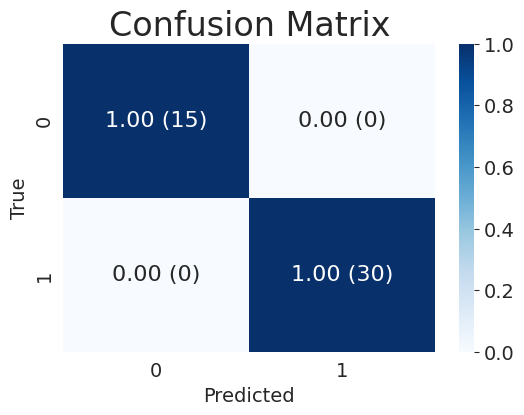

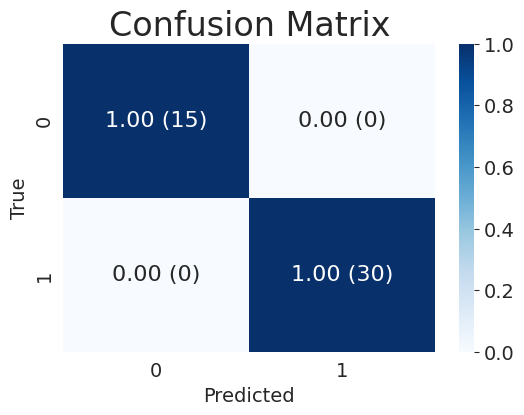

<Figure size 640x480 with 0 Axes>

In [6]:
%run -i Test.py